# Dependency RNNs

To try to embed words and dependency relations s.t. they are predictive of relations, consider using a simple RNN or LSTM/GRU to predict the target noun

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams['figure.figsize'] = (16,9)

In [2]:
import data_helper as dh

In [3]:
# reload(dh)

In [4]:
# reload(tf)

## Dataset Curation

In [119]:
semeval_train, semeval_valid = dh.load_semeval_data()
label2int = dh.label2int
int2label = {v:k for (k,v) in label2int.items()}

In [120]:
# create a vocab and dependency vocab
vocab_size = 100000
(vocab, vocab2int, int2vocab, vocab_dist) = (dh.create_vocab_from_data(
                                                  [datum[0] for datum in (semeval_train['x']+semeval_valid['x'])],
                                                  vocab_limit=vocab_size,
                                                  filter_oov=False))
# assert len(vocab) == vocab_size, "We don't have enough embeddings for those"
vocab_set = set(vocab)
print("Vocab size: %i" % len(vocab_set))
(dep_vocab, dep2int, int2dep, dep_dist) = (dh.create_vocab_from_data(
                                                  [datum[0] for datum in (semeval_train['x']+semeval_valid['x'])],
                                                  vocab_limit=50,
                                                  filter_oov=False,
                                                  dep=True))
dep_set = set(dep_vocab)
print("Dependency vocab size: %i" %len(dep_set))

Vocab size: 19300
Dependency vocab size: 45


In [121]:
print(semeval_train['x'][0][0])

the system as described above has its greatest application in an arrayed configuration of antenna elements


In [122]:
print("Before OOV: %i training sentences and %i validation" % (len(semeval_train['x']), len(semeval_valid['x'])))
semeval_train['x'], semeval_train['y'] = zip(*[ (datum, label) for (datum, label) 
                                                in zip(semeval_train['x'], semeval_train['y'])
                                                if not dh.is_oov(datum[0], vocab_set)])
semeval_valid['x'], semeval_valid['y'] = zip(*[ (datum, label) for (datum, label) 
                                                in zip(semeval_valid['x'], semeval_valid['y'])
                                                if not dh.is_oov(datum[0], vocab_set)])
print("After OOV: %i training sentences and %i validation" % (len(semeval_train['x']), len(semeval_valid['x'])))

Before OOV: 7109 training sentences and 891 validation
After OOV: 7109 training sentences and 891 validation


In [123]:
train_x, train_y = dh.convert_semeval_to_sdps(semeval_train['x'], semeval_train['y'], 
                                           vocab2int, dep2int,
                                           int2label, label2int,
                                           include_reverse=True,
                                           print_check=False)
valid_x, valid_y = dh.convert_semeval_to_sdps(semeval_valid['x'], semeval_valid['y'], 
                                           vocab2int, dep2int,
                                           int2label, label2int,
                                           include_reverse=True, 
                                           print_check=False)
print("\nAfter SDP conversion: %i training sentences and %i validation" 
      % (len(train_x), len(valid_x)))

ERROR: This sentence has no common dependency ancestor.  It was probably parsed incorrectly. SKIPPING
the doctor implanted an injection into three vertical glabellar furrows
[the , doctor , implanted , an , injection , into , three , vertical , glabellar , furrows]
4 9 [injection , implanted ] [furrows]
ERROR: This sentence has no common dependency ancestor.  It was probably parsed incorrectly. SKIPPING
this speed bag plaform is made of heavy duty powder coated steel that secures easily to a wood stud, brick or concrete
[this , speed , bag , plaform , is , made , of , heavy , duty , powder , coated , steel , that , secures , easily , to , a , wood , stud, , , brick , or , concrete]
3 11 [plaform , made ] [steel ]
ERROR: This sentence has no common dependency ancestor.  It was probably parsed incorrectly. SKIPPING
also, very rarely, hypnotherapy leads to the development of 'false memories' fabricated by the unconscious mind these are called confabulations
[also, , , very , rarely, , , h

In [124]:
# quick taste of data:
print(train_x[0], train_y[0])

[3352, 5, 1445, 23, 1445, 5, 3352, 1, 2151] 0


# Model instantiation and training

In [125]:
max_sequence_len = max([len(x) for x in (train_x+valid_x)])
print("Max Sequence Length: %i" % max_sequence_len)

Max Sequence Length: 28


In [249]:
class DPRNN(object):
    """ Encapsulation of the dependency RNN lang model
    
    Largely inspired by https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/ptb_word_lm.py
    """
    def __init__(self, config):
        self.batch_size = config['batch_size']
        self.max_num_steps = config['max_num_steps']
        self.embedding_size = config['embedding_size']
        self.hidden_size = config['hidden_size']
        self.max_grad_norm = config['max_grad_norm']
        self.vocab_dist = config['vocab_dist']
        self.vocab_size = len(self.vocab_dist)
        self.nce_num_samples = config['nce_num_samples']
        self.checkpoint_prefix = config['checkpoint_prefix']
        
        self.initializer = tf.random_uniform_initializer(-1., 1.)
        
        with tf.name_scope("Forward"):
            self._build_forward_graph()
        with tf.name_scope("Backward"):
            self._build_train_graph()
        with tf.name_scope("Predict"):
            self._build_predict_graph()
        
        self.saver = tf.train.Saver(tf.all_variables())
            
        self.session = tf.InteractiveSession()
        self.session.run(tf.initialize_all_variables())        
        self.summary_writer = tf.train.SummaryWriter("tensor_summaries/", self.session.graph_def)

        
    def _build_forward_graph(self):
        # TODO: Add summaries
        # input tensor of zero padded indices to get to max_num_steps
        # None allows for variable batch sizes
        with tf.name_scope("Inputs"):
            self._input_data = tf.placeholder(tf.int32, [None, self.max_num_steps])
            self._input_labels = tf.placeholder(tf.int32, [None, self.max_num_steps])
            self._input_lengths = tf.placeholder(tf.int32, [None, 1]) 
            batch_size = tf.shape(self._input_lengths)[0]
        
        with tf.name_scope("Word_Embeddings"):
            self._word_embeddings = tf.get_variable("word_embeddings", 
                                                    [self.vocab_size, self.embedding_size],
                                                    dtype=tf.float32)
        
            input_embeds = tf.nn.embedding_lookup(self._word_embeddings, self._input_data)
            print(input_embeds.get_shape())
            # TODO: Add dropout to embeddings
        
        with tf.name_scope("RNN"):
            # start off with the most basic configuration
            self.cell = tf.nn.rnn_cell.BasicRNNCell(self.hidden_size)#, input_size=self.embedding_size)
            # TODO: Add Dropout wrapper
            # TODO: Make it multilevel
            self._initial_state = self.cell.zero_state(batch_size, tf.float32)
            inputs = [ tf.squeeze(input_, [1]) for input_ in tf.split(1, self.max_num_steps, input_embeds)]

            outputs, state = tf.nn.rnn(self.cell, inputs, 
                                           sequence_length=tf.squeeze(self._input_lengths, [1]),
                                           initial_state=self._initial_state)
            self._final_state = state
            output = tf.reshape(tf.concat(1, outputs), [-1, self.hidden_size])
        
        # now get unnormalized predictions
        with tf.name_scope("Softmax"):
            self._softmax_w = tf.get_variable("softmax_w", [self.vocab_size, self.hidden_size, ], dtype=tf.float32)
            self._softmax_b = tf.get_variable("softmax_b", [self.vocab_size], dtype=tf.float32)
#             self._logits = tf.matmul(output, self._softmax_w) + self._softmax_b
        
        # loss is classification cross entropy for each word
        # NOTE: that where we have 0 outputs the loss contribution 
        #       is only the log(bias) of that vocab word
        with tf.name_scope("Cost"):
            # Softmax loss is SUPER slow. Softmaxes of 20,000 words is very slow
#             flat_labels = tf.reshape(self._input_labels, [-1])
#             self._loss = tf.nn.seq2seq.sequence_loss_by_example(
#                             [self._logits],
#                             [flat_labels], # [num_steps*batch_size]
#                             [tf.ones_like(flat_labels, dtype=tf.float32)]) # weights to for each example
            # Use NCE instead
            flat_labels = tf.reshape(self._input_labels, [-1, 1])
            sampler = tf.nn.fixed_unigram_candidate_sampler(true_classes=tf.to_int64(flat_labels), 
                                                            num_true=1, 
                                                            num_sampled=self.nce_num_samples, 
                                                            unique=True, 
                                                            range_max=self.vocab_size,
                                                            distortion=.75,
                                                            num_reserved_ids=0,
                                                            unigrams=self.vocab_dist,
                                                            seed=0,
                                                            name=None)
            self._cost = tf.reduce_mean(tf.nn.nce_loss(weights=self._softmax_w, 
                                             biases=self._softmax_b, 
                                             inputs=output, 
                                             labels=tf.to_int64(flat_labels), 
                                             num_sampled=self.nce_num_samples, 
                                             num_classes=self.vocab_size, 
                                             num_true=1, 
                                             sampled_values=sampler, 
                                             remove_accidental_hits=False, 
                                             name='nce_loss'))
            
            self._train_cost_summary = tf.merge_summary([tf.scalar_summary("Train_NCE_Loss", self._cost)])
            self._valid_cost_summary = tf.merge_summary([tf.scalar_summary("Validation_NCE_Loss", self._cost)])
            # add another dimension so tf doesn't get made about NoneType tensors
#             self._cost = tf.reduce_mean(loss)
#             print(loss.get_shape(), self._cost.get_shape())
        
    def _build_train_graph(self):
        with tf.name_scope("Trainer"):
            self._global_step = tf.Variable(0, name="global_step", trainable=False)
            self._lr = tf.Variable(1.0, trainable=False)
            self._optimizer = tf.train.AdagradOptimizer(self._lr)
            
            # clip and apply gradients
            grads_and_vars = self.optimizer.compute_gradients(self._cost)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._grad_summaries = tf.merge_summary(grad_summaries)
            self._train_op = self._optimizer.apply_gradients(clipped_grads_and_vars, global_step=self._global_step)
            
    def _build_predict_graph(self):
        tf.get_variable_scope().reuse_variables()
        with tf.name_scope("Inputs"):
            self._predict_inputs = tf.placeholder(tf.int32, [None, self.max_num_steps])
            self._predict_lengths = tf.placeholder(tf.int32, [None, 1])
        
        with tf.name_scope("Word_Embeddings"):
            predict_embeds = tf.nn.embedding_lookup(self._word_embeddings, self._predict_inputs)
        
        with tf.name_scope("RNN"):
            predict_inputs = [tf.squeeze(input_, [1]) for input_
                              in tf.split(1, self.max_num_steps, predict_embeds)]
            _initial_state = self.cell.zero_state(tf.shape(self._predict_lengths)[0], tf.float32)
            predict_outputs, predict_state = tf.nn.rnn(self.cell, predict_inputs, 
                                                       sequence_length=tf.squeeze(self._predict_lengths, [1]), 
                                                       initial_state=_initial_state)
        with tf.name_scope("Softmax_and_predict"):
            predict_outputs = tf.reshape(tf.concat(1,predict_outputs), [-1, self.hidden_size])
            predict_logits = tf.matmul(predict_outputs, self.softmax_w, transpose_b=True) + self._softmax_b
            self._predicted_dists = tf.nn.softmax(predict_logits)
            self._predictions = tf.reshape(tf.argmax(predict_logits, 1), [-1, self.max_num_steps])
            
    def partial_fit(self, batch_x, batch_y, batch_seq_lens):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        feed = {self._input_data:batch_x, 
                self._input_labels:batch_y,
                self._input_lengths:batch_seq_lens}
#         print(feed)
#         print(batch_x, batch_y, batch_seq_lens)
        cost, _, g_summaries, c_summary = self.session.run([self._cost, self._train_op, 
                                             self._grad_summaries,
                                             self._train_cost_summary], feed_dict=feed)
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)
#         print(cost)
        perp = cost# np.exp(cost)
        return perp
    
    def validation_cost(self, batch_x, batch_y, batch_seq_lens):
        """Run a forward pass of the RNN on a batch of validation data 
        and report the perplexity
        """
        feed = {self._input_data:batch_x, 
                self._input_labels:batch_y,
                self._input_lengths:batch_seq_lens}
#         print(feed)
        cost, valid_cost_summary = self.session.run([self._cost, self._valid_cost_summary], feed_dict=feed)
        self.summary_writer.add_summary(valid_cost_summary)
        perp = cost #np.exp(cost)
        return perp
        
    def predict(self, sequences, seq_lens, return_probs=False):
        if return_probs:
            predictions, distributions = self.session.run([self._predictions, self._predicted_dists],
                                                          {self._predict_inputs:sequences,
                                                           self._predict_lengths:seq_lens})
            distributions = distributions.reshape([sequences.shape[0], sequences.shape[1], -1])
            pred_list = []
            dist_list = []
            for i, seq_len in enumerate(seq_lens):
                pred_list.append(list(predictions[i, :seq_len]))
                dist_list.append([distributions[i,j,:] for j in range(seq_len)])
            return pred_list, dist_list
        
        else:
            predictions = self.session.run(self._predictions,
                                           {self._predict_inputs:sequences,
                                            self._predict_lengths:seq_lens})
            pred_list = []
            for i, seq_len in enumerate(seq_lens):
                pred_list.append(list(predictions[i, :seq_len])) 
            return pred_list
            
    def checkpoint(self):
        self.saver.save(self.session, self.checkpoint_prefix, global_step=self._global_step)
        
    def __repr__(self):
        return "<DPNN: Embed:%i, Hidden:%i, V:%i>" % (self.embedding_size, self.hidden_size, self.vocab_size)
        
    @property
    def input_data(self):
        return self._input_data
    
    @property
    def labels(self):
        return self._labels
    
    @property
    def input_lengths(self):
        return self._input_lengths
    
    @property
    def initial_state(self):
        return self._initial_state
    
    @property
    def final_state(self):
        return self._final_state
    
    @property
    def word_embeddings(self):
        return self._word_embeddings
    
    @property
    def softmax_w(self):
        return self._softmax_w
    
    @property
    def softmax_b(self):
        return self._softmax_b
    
    @property
    def loss(self):
        return self._loss
    
    @property
    def cost(self):
        return self._cost
    
    @property
    def lr(self):
        return self._lr
    
    @property
    def optimizer(self):
        return self._optimizer
    @property
    def train_op(self):
        return self._train_op

In [250]:
# tf.reset_default_graph()

In [251]:
max_sequence_len = max([len(x) for x in (train_x+valid_x)])
print("Max Sequence Length: %i" % max_sequence_len)

Max Sequence Length: 28


In [252]:
# fake easy dataset
# easy_sentences = [dh.nlp(u"the quick brown fox jumps over the lazy dog")]*100

In [253]:
# (vocab, vocab2int, int2vocab, vocab_dist) = dh.create_vocab_from_data(easy_sentences)
# # print(vocab_dist)
# easy_data = dh.sentences_to_indices(easy_sentences, vocab2int)
# easy_data[::2].pop()
# random.seed(0)
# for i, s in enumerate(easy_data):
#     r = random.randint(0,3)
#     if r:
#         easy_data[i] = s[:-r]
# max_seq_len = max([len(d) for d in easy_data])
# print("Max seq len: %i" % max_seq_len)
# # for i, s in enumerate(easy_data):
# #     print(i, s)

In [254]:
# tf.get_default_session().close()
tf.reset_default_graph()
k = 20
config = {
    'batch_size':100,
    'max_num_steps':max_sequence_len,
    'embedding_size':200,
    'hidden_size':200,
    'max_grad_norm':3.,
    'vocab_dist':vocab_dist,
    'nce_num_samples':25,
    'checkpoint_prefix':'checkpoints/dprnn_test1'
}
try:
    drnn = DPRNN(config)
    print("No need for new setup")
except:
    try:
        tf.reset_default_graph()
    except:
        pass
    try:
        tf.get_default_session().close()
    except:
        pass
    print("Needed a new setup")
    drnn = DPRNN(config)
print(drnn)

(?, 28, 200)
No need for new setup
<DPNN: Embed:200, Hidden:200, V:19300>


In [255]:
def sequences_to_matrix(list_of_lists, max_seq_len=None):
    lengths = np.array([len(list_) for list_ in list_of_lists]).reshape([-1, 1])
    if max_seq_len:
        assert max_seq_len >= max(lengths), "Currently cant force sequnece lengths to be shorter than max list len"
    else:
        max_seq_len = max(lengths)
    matrix = np.zeros([len(list_of_lists), max_seq_len])
    for i, list_ in enumerate(list_of_lists):
        matrix[i, :len(list_)] = list_
    return matrix, lengths

In [256]:
def generate_lang_model_batch(offset, batch_size, data_x, max_seq_len=None):
    """Expects the data as list of lists of indices
    
    Converts them to matrices of indices, lang model labels, and lengths"""
    start = offset*batch_size
    end = start + batch_size
    if end > len(data_x):
        end = len(data_x)
        print("Not full batch")
    batch = data_x[start:end]
    inputs = [ seq[:-1] for seq in batch ]
    labels = [ seq[1:] for seq in batch ]
    input_mat, len_vec = sequences_to_matrix(inputs, max_seq_len=max_sequence_len)
    label_mat, _ = sequences_to_matrix(labels, max_seq_len=max_sequence_len)
    return input_mat.astype(np.int32), label_mat.astype(np.int32), len_vec.astype(np.int32)

In [257]:
print(drnn.vocab_size)

19300


In [258]:
num_epochs = 100
batch_size = config['batch_size']
data_size = len(train_x)
num_steps = data_size // batch_size
for epoch in range(num_epochs):
    # shuffle the data order
    random.shuffle(train_x)
    for step in range(num_steps):
        batch = generate_lang_model_batch(step, batch_size, train_x,
                                          max_seq_len=max_sequence_len)
#         print(batch[0].shape, batch[1].shape, batch[2].shape)
        perplexity = drnn.partial_fit(*batch)
        if step % 10 == 0:
            print("%i:%i Training NCE Loss = %1.5f" % (step, epoch, perplexity))
        if epoch*num_steps + step % 20 == 0:
            valid_perplexity = drnn.validation_cost(
                                    *generate_lang_model_batch(0, len(valid_x), valid_x,
                                                               max_seq_len=max_sequence_len))
            print("%i:%i Validation NCE Loss = %1.5f" % (step, epoch, valid_perplexity))
        if epoch*num_steps + step % 100 == 0:
            print("Saving model...")
            drnn.checkpoint()
            

0:0 Training NCE Loss = 140.32471
0:0 Validation NCE Loss = 118.37694
Saving model...
10:0 Training NCE Loss = 135.89705
20:0 Training NCE Loss = 155.09639
30:0 Training NCE Loss = 126.22244
40:0 Training NCE Loss = 145.08957
50:0 Training NCE Loss = 139.22038
60:0 Training NCE Loss = 138.61949
70:0 Training NCE Loss = 111.83234
80:0 Training NCE Loss = 133.29344
90:0 Training NCE Loss = 124.65572
100:0 Training NCE Loss = 128.81853
100:0 Validation NCE Loss = 118.08834
Saving model...
110:0 Training NCE Loss = 149.39264
120:0 Training NCE Loss = 142.73241
130:0 Training NCE Loss = 130.18723
140:0 Training NCE Loss = 138.70583
0:1 Training NCE Loss = 132.83295
10:1 Training NCE Loss = 129.24567
20:1 Training NCE Loss = 123.68953
30:1 Training NCE Loss = 105.59384
40:1 Training NCE Loss = 97.29975
50:1 Training NCE Loss = 101.52982
60:1 Training NCE Loss = 128.57121
70:1 Training NCE Loss = 106.47817
80:1 Training NCE Loss = 125.34081
90:1 Training NCE Loss = 135.95772
100:1 Training NC

In [266]:
drnn.checkpoint()

In [259]:
preds, dists = drnn.predict(*sequences_to_matrix(test_data, max_seq_len=max_seq_len), return_probs=True)
for sentence, pred in zip(test_sentences, preds):
    print(sentence, [int2vocab[p] for p in pred])
    
last_preds = [ pred[-1] for pred in preds ]
last_dists = [ dist[-1] for dist in dists ]
fig, axs = plt.subplots(len(test_data), 1, figsize=(16,16))
plt.tight_layout()
for i, dist in enumerate(last_dists):
    axs[i].set_title(u" ".join([t.text for t in test_sentences[i]]) + " __? :: " + int2vocab[last_preds[i]] )
    axs[i].stem(dist)
    axs[i].set_xticks(range(len(vocab)))
    axs[i].set_xticklabels(vocab)
    axs[i].set_xlim([-1, 9])

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1515354d0>> ignored


NameError: name 'test_data' is not defined

In [442]:
# fig, ax = plt.subplots()
# im = ax.imshow(drnn.word_embeddings.eval(), interpolation='nearest')
# ax.set_yticklabels(vocab)
# # print(vocab)
# fig.colorbar(im)

In [441]:
# plt.imshow(drnn.softmax_w.eval(), interpolation='nearest')
# plt.colorbar()

In [440]:
# fig, axs = plt.subplots(1,2, figsize=(16,16))
# fig.tight_layout()
# im = axs[0].imshow(drnn.rnn_i.eval(), interpolation='nearest')
# # axs[0].set_ylabel("%i"% i)
# im = axs[1].imshow(drnn.rnn_h.eval(), interpolation='nearest')
# fig.colorbar(im)
# # axs[0].set_ylabel("%i"% i)
# # cbar_ax = fig.add_axes([-.1, 0.15, 0.05, 0.7])
# # fig.colorbar(im, cax=cbar_ax)
# # fig, axs = plt.subplots(8,1, figsize=(16,16))
# # fig.tight_layout()
# # for i in range(len(outputs)):
# #     im = axs[i].imshow(outputs[i], interpolation='nearest')
# #     axs[i].set_ylabel("%i"% i)
# #     axs[i].set_yticks(range(10))
# #     axs[i].set_aspect('auto')
# # cbar_ax = fig.add_axes([-.1, 0.15, 0.05, 0.7])
# # fig.colorbar(im, cax=cbar_ax)

In [264]:
num_points = 100 #len(vocab)
a =1000
from sklearn.manifold import TSNE

embeddings = drnn.word_embeddings.eval()

tsne = TSNE(perplexity=5, n_components=2, 
            init='pca', n_iter=5000,
            verbose=1,
            learning_rate=100,
            random_state=0)
nn_2d_embeddings = tsne.fit_transform(embeddings[a:a+num_points])
# levy_2d_embeddings = tsne.fit_transform(levy_embeddings[:num_points])

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.068572
[t-SNE] Error after 94 iterations with early exaggeration: 17.813980
[t-SNE] Error after 210 iterations: 1.456491


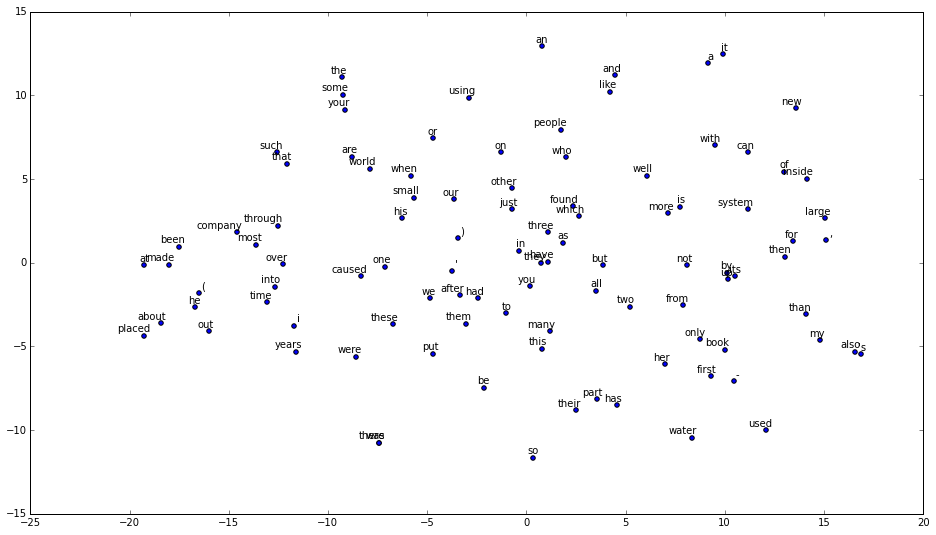

In [265]:
# fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,18))
fig, ax0 = plt.subplots()
for i, label in enumerate(vocab[:num_points]):
    x, y = nn_2d_embeddings[i,:]
    ax0.scatter(x, y)
    ax0.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    
# for i, label in enumerate(vocab[:num_points]):
#     x, y = levy_2d_embeddings[i,:]
#     ax1.scatter(x, y)
#     ax1.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

In [132]:
a = np.array([1.2, 2.4])
a.astype(np.int32)

array([1, 2], dtype=int32)